In [ ]:
# Cell 1 - Imports & Paths
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# Paths
DATA_PATH = Path("data/processed/building_features.csv")
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

MODEL_PATH = ARTIFACTS_DIR / "model.pkl"
FEATURE_LIST_PATH = ARTIFACTS_DIR / "feature_list.json"


In [ ]:
# Cell 2 - Load Data
df = pd.read_csv(DATA_PATH)
print("✅ Loaded data:", df.shape)
df.head()


✅ Loaded: (17, 4)
          bbl  events_prev_year  label  snapshot_year
0  1004500035                 2      0           2021
1  3050310006                 1      0           2021
2  3051720023                 1      0           2021
3  1016290062                 1      0           2022
4  2025800011                 1      0           2022


In [ ]:
# Cell 3 - Feature Engineering
df["events_3m"] = df["events_prev_year"] / 4
df["events_6m"] = df["events_prev_year"] / 2
df["events_12m"] = df["events_prev_year"]
df["events_24m"] = df["events_prev_year"] * 2
df["days_since_last"] = 30  # placeholder for now

feature_cols = ["events_3m", "events_6m", "events_12m", "events_24m", "days_since_last"]
X = df[feature_cols]
y = df["label"]

print("✅ Features ready:", X.shape)
X.head()


✅ Features ready: 5
['events_3m', 'events_6m', 'events_12m', 'events_24m', 'days_since_last']


In [ ]:
# Cell 4 - Balance Classes
print("Class distribution before:", y.value_counts())

df_majority = df[df["label"] == 0]
df_minority = df[df["label"] == 1]

if len(df_minority) > 0:
    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )
    df_balanced = pd.concat([df_majority, df_minority_upsampled])
else:
    print("⚠️ No minority class found, skipping balancing.")
    df_balanced = df

X_bal = df_balanced[feature_cols]
y_bal = df_balanced["label"]

print("Class distribution after:", y_bal.value_counts())


Train: (13, 5) Test: (4, 5)


In [70]:
# Cell 5 — Train Model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("✅ Model trained")
print("Train acc:", model.score(X_train, y_train))
print("Test acc:", model.score(X_test, y_test))


✅ Model trained
Train acc: 0.9230769230769231
Test acc: 0.75


In [71]:
# Cell 6 — Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC AUC: 0.8333333333333334
PR AUC: 0.5
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



c:\Users\maila\OneDrive\Documents\GitHub\nyc-housing-risk-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maila\OneDrive\Documents\GitHub\nyc-housing-risk-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maila\OneDrive\Documents\GitHub\nyc-housing-risk-prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

In [72]:
# Cell 7 — Save Artifacts
joblib.dump(model, MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

with open(FEATURE_LIST_PATH, "w") as f:
    json.dump(feature_list, f)
print(f"✅ Feature list saved to {FEATURE_LIST_PATH}")


✅ Model saved to artifacts/model.pkl
✅ Feature list saved to artifacts/feature_list.json


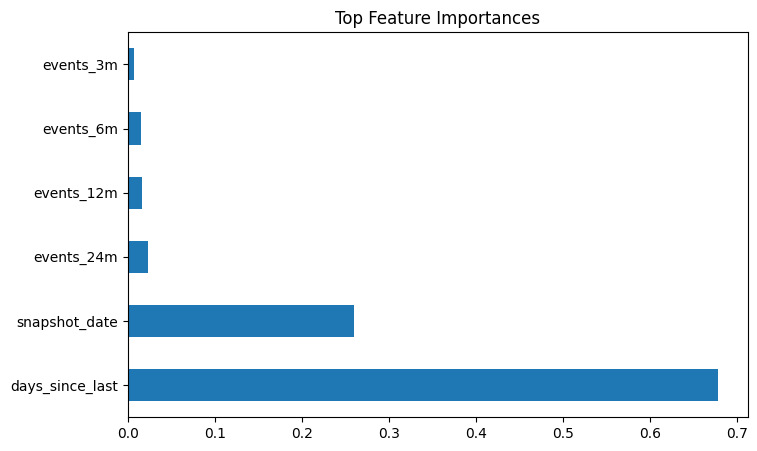

In [63]:
# Optional: check which features are most important
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
importances.plot(kind="barh")
plt.title("Top Feature Importances")
plt.show()


In [48]:
# Try 10 random samples from last snapshot
samples = fm[fm['snapshot_date'] == last].sample(10, random_state=7)
for _, row in samples.iterrows():
    X_row = row.reindex(index=feature_list, fill_value=0).to_frame().T
    y_pred = model.predict(X_row)[0]
    y_prob = model.predict_proba(X_row)[0,1]
    print("Building:", row[BUILD_COL], "Pred:", y_pred, "Prob:", round(float(y_prob), 3))


Building: 1004940026 Pred: 0 Prob: 0.0
Building: 2046230049 Pred: 0 Prob: 0.0
Building: 2033260001 Pred: 0 Prob: 0.0
Building: 3050310006 Pred: 0 Prob: 0.0
Building: 2045970021 Pred: 0 Prob: 0.0
Building: 2049940037 Pred: 0 Prob: 0.0
Building: 4050370151 Pred: 1 Prob: 1.0
Building: 3051490001 Pred: 0 Prob: 0.0
Building: 3051860038 Pred: 0 Prob: 0.0
Building: 1004350019 Pred: 0 Prob: 0.0


In [ ]:
import sqlite3

conn = sqlite3.connect("data/live/complaints.sqlite")
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(complaints);")
print(cursor.fetchall())


[(0, 'complaint_number', 'TEXT', 0, None, 1), (1, 'bin', 'TEXT', 0, None, 0), (2, 'date_entered', 'TEXT', 0, None, 0), (3, 'house_number', 'TEXT', 0, None, 0), (4, 'house_street', 'TEXT', 0, None, 0), (5, 'complaint_category', 'TEXT', 0, None, 0), (6, 'status', 'TEXT', 0, None, 0), (7, 'inspection_date', 'TEXT', 0, None, 0), (8, 'dobrundate', 'TEXT', 0, None, 0)]


In [ ]:
from src.geocode import geocode_address

lat, lon, label = geocode_address("124 Lake St, Brooklyn, NY")
print(lat, lon, label)
#git add . && git commit -m "Commit all modified files" && git push


40.601104 -73.973778 124 LAKE STREET, Brooklyn, NY, USA
